In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
layout = pd.read_csv('/home/michael/Documents/brfss2016_layout.csv',
                    names=['StartCol', 'Name', 'Length'])
keep_columns = ['_STATE', 'GENHLTH', '_RFBMI5', 'SLEPTIM1', '_RFSMOK3', 'DRNKANY5', 'EXERANY2']
layout_filtered = layout[layout['Name'].isin(keep_columns)]
colspecs = list(zip(layout_filtered['StartCol'] - 1,
                    layout_filtered['StartCol'] + layout_filtered['Length'] - 1))
df16 = pd.read_fwf('/home/michael/Documents/LLCP2016.asc', colspecs=colspecs,
                   header=None, names=layout_filtered['Name'])
df16 = df16[~df16['_STATE'].isin([11, 66, 72, 78])] # Drop DC, Guam, Puerto Rico, Virgin Islands
state_code = np.sort(df16['_STATE'].unique())
state_abbrev = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
                'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
                'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
                'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
                'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
state_dict = dict(zip(state_code, state_abbrev))
df16['STCODE'] = df16['_STATE'].replace(state_dict)

In [6]:
layout = pd.read_csv('/home/michael/Documents/brfss2011_layout.csv',
                     names=['StartCol', 'Name', 'Length'])
keep_columns = ['_STATE', 'GENHLTH', '_RFBMI5', 'SLEPTIM1', '_RFSMOK3', 'DRNKANY5', 'EXERANY2']
layout_filtered = layout[layout['Name'].isin(keep_columns)]
colspecs = list(zip(layout['StartCol'] - 1,
                    layout['StartCol'] + layout['Length'] - 1))
df11 = pd.read_fwf('/home/michael/Documents/LLCP2011.ASC', colspecs=colspecs,
                header=None, names=layout['Name'])
df11 = df11[~df11['_STATE'].isin([11, 66, 72])] # Drop DC, Guam, Puerto Rico
df11['STCODE'] = df11['_STATE'].replace(state_dict)

In [8]:
filtered_dfs = [[],[]]
categories = ['2011', '2016']

for i, df in enumerate([df11, df16]):
    filtered_dfs[i] = df[['GENHLTH', 'STCODE', '_RFSMOK3', 'DRNKANY5', 'EXERANY2', '_RFBMI5',]]
    filtered_dfs[i] = filtered_dfs[i][filtered_dfs[i]['GENHLTH'].isin([1,2,3,4,5]) &
                                      filtered_dfs[i]['_RFSMOK3'].isin([1,2]) &
                                      filtered_dfs[i]['DRNKANY5'].isin([1,2]) &
                                      filtered_dfs[i]['EXERANY2'].isin([1,2])]
    filtered_dfs[i]['NonSmoker'] = filtered_dfs[i]['_RFSMOK3'] == 1
    filtered_dfs[i]['NonDrinker'] = filtered_dfs[i]['DRNKANY5'] == 2
    filtered_dfs[i]['Exercise'] = filtered_dfs[i]['EXERANY2'] == 1
    filtered_dfs[i]['NotOverweight'] = filtered_dfs[i]['_RFBMI5'] == 1

fit_vars = ['NonDrinker', 'NonSmoker', 'NotOverweight', 'Exercise']
agg_5yr = np.zeros((2, len(fit_vars)))

for i, df in enumerate(filtered_dfs):
    print(categories[i])
    col = 0
    for var in fit_vars:
        truelevel = np.mean(df['GENHLTH'][df[var] == True])
        falselevel = np.mean(df['GENHLTH'][df[var] == False])
        print('Mean GENHLTH for {} = True: {}'.format(var, truelevel))
        print('Mean GENHLTH for {} = False: {}'.format(var, falselevel))
        print('Difference = {}'.format(falselevel - truelevel))
        agg_5yr[i, col] = falselevel - truelevel
        col += 1

2011
Mean GENHLTH for NonDrinker = True: 3.1725637360019063
Mean GENHLTH for NonDrinker = False: 2.7009619210335387
Difference = -0.4716018149683676
Mean GENHLTH for NonSmoker = True: 2.943372677673573
Mean GENHLTH for NonSmoker = False: 2.8116931295444427
Difference = -0.1316795481291302
Mean GENHLTH for NotOverweight = True: 2.7746521374685664
Mean GENHLTH for NotOverweight = False: 2.9943629243943373
Difference = 0.21971078692577084
Mean GENHLTH for Exercise = True: 2.7391233168256046
Mean GENHLTH for Exercise = False: 3.2101177242409884
Difference = 0.4709944074153838
2016
Mean GENHLTH for NonDrinker = True: 2.802068946209265
Mean GENHLTH for NonDrinker = False: 2.353456370756615
Difference = -0.44861257545264976
Mean GENHLTH for NonSmoker = True: 2.501760173698578
Mean GENHLTH for NonSmoker = False: 2.9583301719297714
Difference = 0.45656999823119326
Mean GENHLTH for NotOverweight = True: 2.3316422087474438
Mean GENHLTH for NotOverweight = False: 2.6775286552611974
Difference = 0.

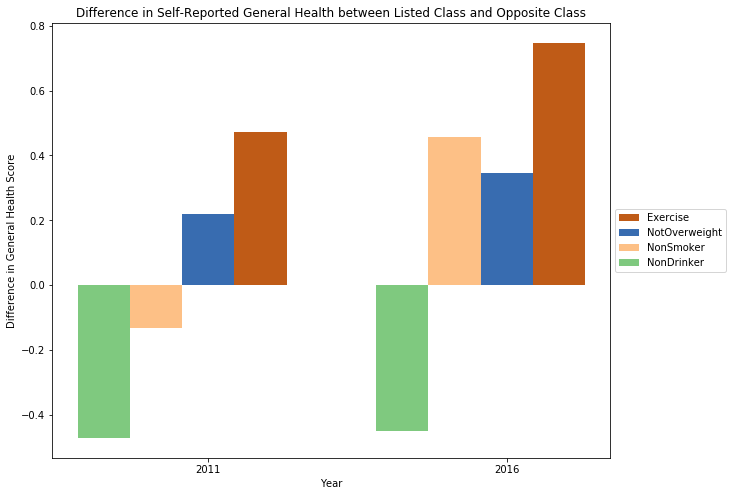

In [9]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

space = 0.3

n = len(fit_vars)

width = (1 - space) / (len(fit_vars))

for i, var in enumerate(fit_vars):
    vals = agg_5yr[:, i]
    pos = [j - (1 - space) / 2. + i * width for j in range(1, len(categories)+1)]
    ax.bar(pos, vals, width=width, label=var, color=cm.Accent(float(i) / n))

ax.set_xticks(range(1, len(categories)+1))
ax.set_xticklabels(categories)
ax.set_xlabel('Year')
ax.set_ylabel('Difference in General Health Score')
ax.set_title('Difference in Self-Reported General Health between Listed Class and Opposite Class')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()